Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [11]:
import requests
import csv
import matplotlib.pyplot as plt

from typing import List, NamedTuple, Dict
from collections import Counter, defaultdict

from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector

In [13]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

Predicting a vote for a person in specific area if we have the neighbourhood data 

## The Model

k-nearest neighbours will not help us to understand the driver of a phenomena
which influents the data. Another model will help, but not k-nearest neighbours

Let's say we've picked a number $k$ like 3 or 5. Then, when we want to classify some new
data point, we find the $k$ nearest labeled points and let them vote on the new output

In [3]:
def raw_majority_vote(labels: List[str]) -> str:
  votes = Counter(labels)
  winner, _ = votes.most_common(1)[0]
  return winner

In [4]:
raw_majority_vote(['a', 'b', 'c', 'b'])

'b'

If we have a tie, the above method would not resolve it.
Let's implement $k$-nearest neighbours

In [5]:
def majority_vote(labels: List[str]) -> str:
  """Assumes that labels are ordered from nearest to farthest.
     The first index position is the origin and the last index
     position is the farthest position"""
  vote_counts = Counter(labels)
  winner, winner_count = vote_counts.most_common(1)[0]
  num_winners = len([count for count in vote_counts.values()
                      if count == winner_count])
  
  if num_winners == 1:
    return winner                       # unique winner, so return it
  else:
    return majority_vote(labels[:-1])   # try again without the farthest


# Tie, so look at first 4, then 'b'
majority_vote(['a', 'b', 'c', 'b', 'a'])

'b'

Improve the above function using `LabeledPoint` class.

In [6]:
class LabeledPoint(NamedTuple):
  point: Vector
  label: str


def knn_classify(k: int, labeled_points: List[LabeledPoint], new_point: Vector) -> str:
  # Order the labeled points from nearest to farthest
  by_distance = sorted(labeled_points, 
                       key=lambda lp: la.distance(lp.point, new_point))
  
  # Find the labels for the k closest
  k_nearest_labels = [lp.label for lp in by_distance[:k]]

  # and let them vote.
  return majority_vote(k_nearest_labels)

In [7]:
# Tie, so look at first 4, then 'b'
majority_vote(['a', 'b', 'c', 'b', 'a'])

'b'

## Example: The Iris Dataset

In [8]:
data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.data', 'w') as f:
  f.write(data.text)

Representing our data using `LabeledPoint`

In [10]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
  """sepal_length, sepal_width, petal_length, petal_width, class"""
  measurements = [float(value) for value in row[:-1]]

  # class is e.g. "Iris-virginica"; we just want "virginica"
  label = row[-1].split("-")[-1]

  return LabeledPoint(measurements, label)


with open("iris.data") as f:
  reader = csv.reader(f)
  iris_data = [parse_iris_row(row) for row in reader]


# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
  points_by_species[iris.label].append(iris.point)

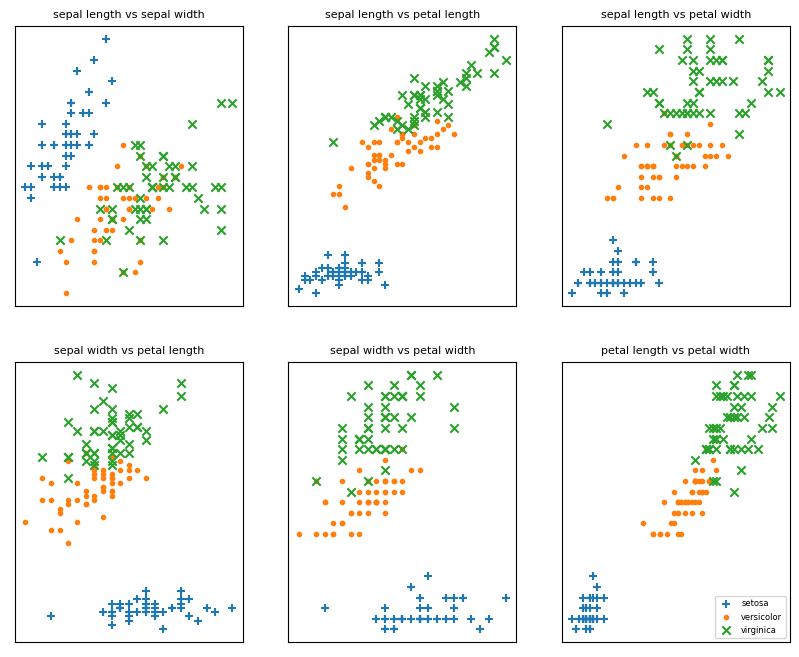

In [17]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']     # we have 3 classes, so 3 markers

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for row in range(2):
  for col in range(3):
    i, j = pairs[3 * row + col]

    ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])

    for mark, (species, points) in zip(marks, points_by_species.items()):
      xs = [point[i] for point in points]
      ys = [point[j] for point in points]

      ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc="lower right", prop={'size': 6})
plt.show()